# Run Tensorboard from inside the Jupyter Notebook

This notebook runs Tensorboard from within while training a very simple RNN.

It is based off my [sine wave predictor](https://github.com/KiranArun/tensorflow/blob/serving/notebooks/wave_predictors/sine_wave_predictor.ipynb).

This works when using datalab on the google cloud platform and on the tensorflow docker image

In [1]:
# Import dependancies
import tensorflow as tf                    # our machine learning library
import numpy as np                         # our python library for dealing with arrays
import matplotlib.pyplot as plt, pylab     # our graphing library
import time                                # for pauses when updating graphs
import subprocess                          # to run tensorboard in the background
import os 

# this is to present our graph interactively 
% matplotlib notebook

In [2]:
# Sometimes I use a gpu and dont want to allocate all of the memoryto his process
# gpu options, 90% of gpu memory assigned to this python kernel
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

# set the size of the state
state_size = 8
# set the number of lines to learn in parallel
# in this case we are just looking at one sine wave 
batch_size = 1

# log directory for tensorboard
logdir = '/content/datalab/logdir/'

# training parameters
iterations = 2000
learning_rate = 1


# number of steps to predict into the future
steps_to_predict = 30
# number of previous points to be inputted, must be >= steps_to_predict
truncated_backprop_length = 30

# total size of training data series
# this calculation will return an array the exact size required
total_series_length = iterations+truncated_backprop_length+steps_to_predict

In [3]:
# set the logdir for this current run
previous_runs = os.listdir(logdir)

# if there have been no runs, set the run number to 1
if len(previous_runs) == 0:
    run_number = 1  
# if there have benn runs, add one to the largest number run
else:
    run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1

# set the current_run_logdir to a directory called run_<run_number> inside the tensorboard logdir
current_run_logdir = '%srun_%02d' % (logdir, run_number)

In [4]:
# kill tensorboard process if already running
! pkill -f /usr/local/bin/tensorboard

# this command runs tensorboard in the background
# it means we can run tensorboard from the notebook and then continue to run the rest of the notebook
subprocess.Popen(["tensorboard", "--port=6006", '--logdir=%s' % logdir])

# if using datalab, run from your local machine:
# gcloud compute ssh <instance-name> --ssh-flag="-L" --ssh-flag="2222:<ip_address>:6006"
# and go to localhost:2222 in your browser
# this will open a port going to tensorboard

# for more info:
# https://cloud.google.com/solutions/connecting-securely


In [5]:
# function to generate training data
def generate_data(length):
    
    # create x data for line with max value of length
    # it increases by 0.1 each step
    x = np.linspace(0,length, length*10+1)
    
    # create y data for line by applying numpy's sin function to x data
    # we reshape so that each time step is in a new layer/page
    # the rows are the batch size and the columns are the features
    y = np.sin(x).reshape(-1,batch_size,1)
    
    # return the y data
    return(y)

In [6]:
# create placeholders for input data and labels
# we are inputting a set of points with an unknown time steps size, but with fixed batch size and features 
# the labels are the values next in the series with size of steps_to_predict
batchX_placeholder = tf.placeholder(tf.float32, [None, batch_size, 1], name='x_data_placeholder')
batchY_placeholder = tf.placeholder(tf.float32, [batch_size, steps_to_predict], name='y_data_placeholder')

# create an initial state placeholder
init_state = tf.placeholder(dtype=tf.float32, shape=[batch_size, state_size], name='initial_state')

# 2nd layer variables
with tf.name_scope('layer_2'):
    # create Weights and a bias for the final layer from the output of the RNN cell
    W2 = tf.Variable(np.random.rand(state_size, 1),dtype=tf.float32)
    b2 = tf.Variable(np.zeros((1)), dtype=tf.float32)
    
    # show the weights and biases as histograms in tensorboard
    tf.summary.histogram('weight2', W2)
    tf.summary.histogram('bias2', b2)

# split the labels into different arrays for each time step
labels_series = tf.split(axis=1, num_or_size_splits=steps_to_predict, value=batchY_placeholder, name='labels')

# set the inputs series to the input array placeholder
inputs_series = batchX_placeholder

In [7]:
# create RNN cell using tensorflows BasicRNNCell function with number of units as state_size
# we are using relu as ou activation function
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size, activation=tf.nn.relu)

with tf.name_scope('rnn_cell'):
    # we are using the dynamic rnn function to call the RNN cell
    # we set the new output series and and the updated current state
    # we input the RNN cell from above, the input series data and  use the initial state which is the current state for this prediction
    
    # time_major = True means that the input data will be in shape [time_steps, batch_size, features] instead of [batch_size, time_steps, features]
    states_series, current_state = tf.nn.dynamic_rnn(cell, inputs_series, initial_state=init_state, time_major=True)
    
    rnn_cell_weights = tf.trainable_variables()[2]
    rnn_cell_biases = tf.trainable_variables()[3]

    # show the state as a histogram in tensorboard
    tf.summary.histogram('current_state', current_state)
    
    # show the weights and biases of this rnn cell in tensorboard
    tf.summary.histogram('rnn_weights', rnn_cell_weights)
    tf.summary.histogram('rnn_biases', rnn_cell_biases)

In [9]:
# initialize the logits series as an empty array
logits_series = []

with tf.name_scope('outputs'):
    # for each outputed set of values, we apply the second weights and biases
    for i in range(steps_to_predict):

        # first, we apply the weights and biases for the final layer
        # we then append the predicted value for this time step to the logits_series list
        logits_series.append(tf.reshape((tf.matmul(states_series[-(steps_to_predict-i)], W2) + b2), shape=[1]))
        
    tf.summary.histogram('predictions', logits_series)
    tf.summary.histogram('labels', labels_series)

with tf.name_scope('loss'):
    # calculate loss using l2 loss as it is using continuous data and not classes
    # repeat this for each value in the logits series
    # then average the loss for all values predicted
    total_loss = tf.reduce_mean([tf.nn.l2_loss(label - logit, name=None) for logit, label in zip(logits_series, labels_series)])
    
    # record the loss as a scalar on tensorboard
    tf.summary.scalar('loss', total_loss)

# we are using Adagrad optimizer
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [10]:
# generate training data
x_data = generate_data(total_series_length)

# initialize a current state with zeros
_current_state = np.zeros(dtype=np.float32, shape=[batch_size, state_size])

# define the summary writer for tensorboard
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(current_run_logdir, graph=tf.get_default_graph())

In [11]:
# start session and initialize variables
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

# start training loop
# start_index is going to be the index for the first value of the input data in the current iteration
for start_index in range(iterations):

    # set the end index to the index of the last value in the input data of this iteration
    end_index = start_index + truncated_backprop_length

    # select input data and labels for current batch
    
    # the input data is selected using the start and end index
    batchX = x_data[start_index:end_index,:,:]
    
    # the labels data is selected from the end of the input data to steps_to_predict number of time steps ahead
    batchY = x_data[end_index:end_index+steps_to_predict,:,:].reshape(1,-1)

    # run the training step feeding in the selected data and the current state
    # return the total_loss to print
    # return the train_step to run the optimizer
    # return the current state to update it to the next state
    # return the logits_series to plot on our graph
    _total_loss, _train_step, _current_state, _summary,  = sess.run([total_loss, train_step, current_state, merged],
        feed_dict={
            batchX_placeholder:batchX,
            batchY_placeholder:batchY,
            init_state:_current_state
        })
    
    # print the index and loss 20 times in total
    if (start_index)%(iterations/20) == 0:
        print 'Step',start_index, 'Loss =', _total_loss

    # every 5 steps write to the tensorboard file in the current_run_logdir
    if start_index % 5 == 0:
        train_writer.add_summary(_summary, start_index)

# print when training has finished
print 'Done Training'

Step 0 Loss = 3.07443
Step 100 Loss = 0.00782418
Step 200 Loss = 0.000689883
Step 300 Loss = 0.00154976
Step 400 Loss = 0.00170774
Step 500 Loss = 0.00344384
Step 600 Loss = 0.00641452
Step 700 Loss = 0.00204027
Step 800 Loss = 0.00411343
Step 900 Loss = 0.000825251
Step 1000 Loss = 0.00178834
Step 1100 Loss = 0.00419694
Step 1200 Loss = 0.00399098
Step 1300 Loss = 0.00435811
Step 1400 Loss = 0.000615566
Step 1500 Loss = 0.00135282
Step 1600 Loss = 0.0027388
Step 1700 Loss = 0.00514292
Step 1800 Loss = 0.00366004
Step 1900 Loss = 0.000466373
Done Training


In [12]:
# function to update plot
def plot_data(X_data,X2_data,Y_data, pred_data, sleep_time):
  
    # plot real line
    ax.plot(X_data,Y_data, 'g')
    # plot predicted line
    ax.plot(X2_data,pred_data, '--r')
    fig.canvas.draw()
    # pause for specified amount of time
    time.sleep(sleep_time)

<IPython.core.display.Javascript object>


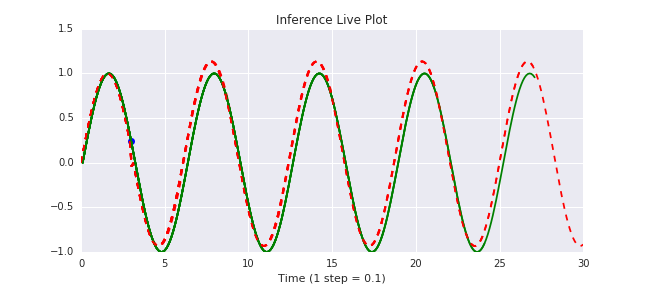

<IPython.core.display.Javascript object>


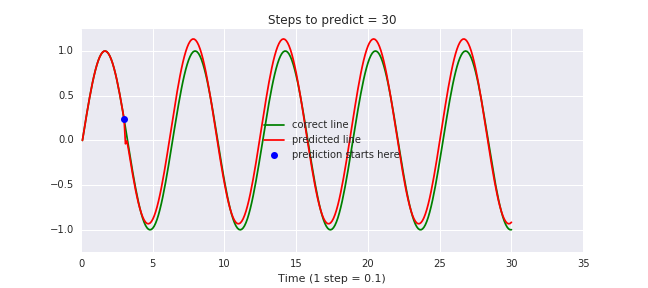

In [13]:
# Test our model

# initialize pred, Y and X arrays as empty
pred = Y = X = np.array([])

# initialize current state for testing
_current_state = np.zeros(dtype=np.float32, shape=[batch_size, state_size])

# this will be our x values 
n = 0

# setup subplot which we'll update during the loop
fig,ax = plt.subplots(1,1, figsize=(9,4))
ax.grid(True)
ax.set_xlabel('Time (1 step = 0.1)')
plt.title('Inference Live Plot')

# loop for 300 steps
for i in range(300):
    
    # Y will be the correct line so we will apply the sin function to it
    Y = np.append(Y, np.sin(n)).reshape(1,-1)
    
    # increase the steps by 0.1
    n += 0.1
    # append X array with current step
    X = np.append(X, n)
    
    
    # if we haven't got enough points to use as input data
    # dont run the prediction and instead use the real points as the prediction line instead
    if i < truncated_backprop_length:
        # append the real line data point/points
        pred = np.append(pred, Y[:,-1])
        
        # update the graph at the same rate as if it was predicting
        if i % steps_to_predict == 0:
            
            # plot the graph using X as our prediction X data
            plot_data(X,X,Y.reshape(-1),pred, 0.1)
            
            
    # plot a blue dot where it starts making predictions
    if i == (truncated_backprop_length-1):
        ax.plot(X[-1],pred[-1], 'bo')
        fig.canvas.draw()
        time.sleep(0.1)

        
    # when we have enough previous points to use as input data, run the prediction
    # run only when the real data has almost caught up with the predicted data
    elif i >= truncated_backprop_length and (i-truncated_backprop_length) % steps_to_predict == 0:
        
        # set previous, our input data, to the last truncated_backprop_length number of points from the real line
        previous = np.array(Y[:,-(truncated_backprop_length+1):-1]).reshape(-1,1,1)
        
        # predict the new values and set the new current state
        # it runs the  output series and only picks the points that have been predicted
        # it ignores the values which were also in the input
        new_values, _current_state = sess.run(
                [logits_series[-(steps_to_predict):truncated_backprop_length], current_state],
                feed_dict={
                    batchX_placeholder:previous,   # input previous
                    init_state:_current_state      # use current state as state
                })

        # append to pred with the predicted value/values
        pred = np.append(pred, new_values)
        
        # X2 is our X values but the same size as pred so we can plot pred before the Y values reach it 
        X2 = np.linspace(0, pred.size/10., pred.size)
        
        # plot the graph using X2 as our prediction X data
        plot_data(X,X2,Y.reshape(-1),pred, 0.3)
        

# set up final plot
fig2,ax2 = plt.subplots(1,1, figsize=(9,4))
ax2.grid(True)
ax2.set_xlabel('Time (1 step = 0.1)')
plt.title('Steps to predict = %i' % steps_to_predict)

# sometimes, the predictions go beyond the real line so we cut them off
pred = pred[0:Y.size]

# plot the correct line, Y
ax2.plot(X,Y[0], 'g', label='correct line')
# plot the predicted line
ax2.plot(X,pred, 'r', label='predicted line')
# plot the point where the prediction starts
ax2.plot(X[truncated_backprop_length-1], pred[truncated_backprop_length-1], 'bo', label='prediction starts here')

# show the labels
plt.legend(loc='center', bbox_to_anchor=(0.5, 0.5))
# set the axis size to 110% the max 
pylab.ylim([-1.1*np.max(np.abs(np.vstack((Y,pred)))),1.1*np.max(np.abs(np.vstack((Y,pred))))])
ax2.grid(True)
# show the plot
plt.show()

In [ ]:
variables_names = [v.name for v in tf.trainable_variables()]
values = sess.run(variables_names)
for k,v in zip(variables_names, values):
    print(k, v)
    
print variables_names[3], values[3]
rnn_cell_weights = values[2]
rnn_cell_biases = values[3]

In [ ]:
rnn_weight = sess.run(tf.trainable_variables()[2])
print rnn_weight